### EDA

I ran an initial model just on my interpretation of the data without doing any EDA. This ended up being a mistake, my test data had about a 60% accuracy, and after EDA it resulted in over 80%. This really solidified the reason why EDA is done. It removes our preconcieved notions about how we think about the data and allows us to make a more accurate decision on including or excluding data

In [48]:
import pandas as pd
import numpy as np

In [49]:
data = pd.read_csv('F:/data science/Jupyter/work file/datasets/competitions/titanic/train.csv')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


I am going to review the datapoints and analyze their statistical significance to survival and see if there is any that I may have missed in my initial pass

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns

#### Embarked

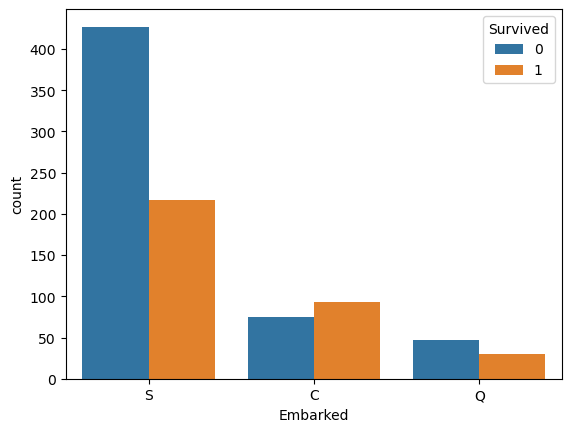

In [52]:
#sns.barplot(x='Sex',y='Survived',data=data,hue='Embarked')
sns.countplot(data=data,x='Embarked',hue='Survived')
plt.show()

looking at the embarkation location doesnt look to radically effect the survival rate, so running some additional statistics to determine the actual effect on survival

In [64]:
from scipy.stats import chi2_contingency,chi2
from scipy.stats import ttest_ind

find the chi2 and p value of the variables to determine significance

In [54]:
# use the crosstab to create a contingency table to run chi2 on
contable = pd.crosstab(data['Embarked'],data['Survived'])

# the chi2 returns 4 variables, chi2, p, expected frequency, additional info. the _ indicates the value is not used
chi2,p,_,_ = chi2_contingency(contable)
print(chi2,p)

26.48914983923762 1.769922284120912e-06


the chi2 is about 26, this has no meaning on its own, you need to find the degrees of freedom of the contingency table<br>
degree = (rows-1)*(columns-1)<br>
<br>
then obtain the critical value and if the chi2 is greater than the critical value you can reject null hypothesis

In [65]:
degree = (len(contable)-1)*(len(contable.columns)-1)
alpha = .05

critical_value = chi2.ppf(1- alpha, degree)
critical_value

14.067140449340169

looking at the p value it is quite a bit lower than .05 alpha set initially, so it looks like embarkation location does have some significance in determining survival. Additionally the chi2 is also greater than the critical value which rejects the null hypo. I ran a quick test looking at survival rates with and without Embarked, and leaving it in results in about a 2% increase in accuracy, so it can be left in

#### Fare

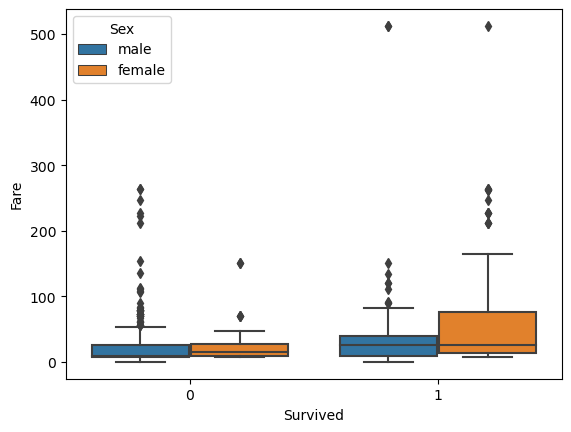

In [57]:
sns.boxplot(data=data,x='Survived',y='Fare',hue='Sex')
plt.show()

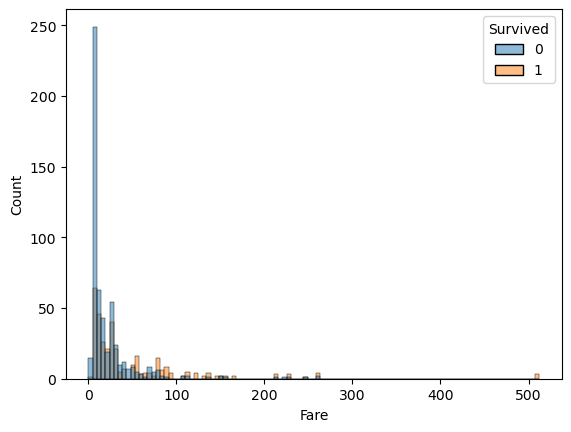

In [58]:
sns.histplot(data=data,x='Fare',hue='Survived')
plt.show()

from these plots there is actually a fairly strong correlation between fare and survival. Upon my first pass of the data I didnt think ticket cost could affect the survival, but actually looking back it makes sense. a person who pays more will be higher on the boat, and be given priority when exiting

In [59]:
# create two groups of values split on the dependent variable
survivefare = data[data['Survived'] == 1]['Fare'].dropna()
nonsurvivefare = data[data['Survived'] == 0]['Fare'].dropna()

t_stat, p_value = ttest_ind(survivefare,nonsurvivefare)
print(t_stat,p_value)

7.939191660871055 6.120189341924198e-15


there is significant significance to the fare, so dropping it in my initial evaluation was a mistake, when I looked to drop fare from the analysis

#### age

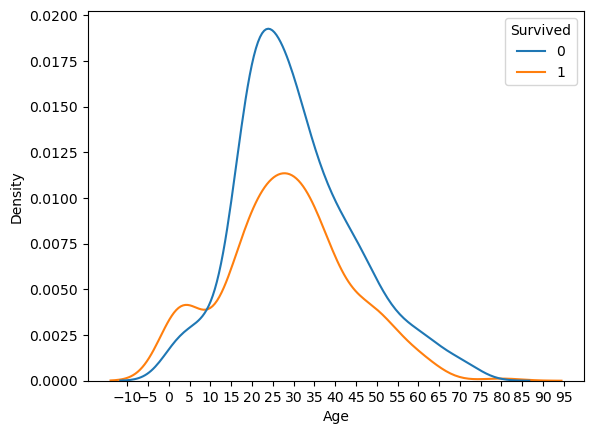

In [60]:
sns.kdeplot(data=data,x='Age',hue='Survived')
plt.xticks(np.arange(-10,100,5))
plt.show()

one thing I missed as well was the likelihood of children surviving, survival is increased for children, so adding a variable to account for that would help with classification

#### Cabin

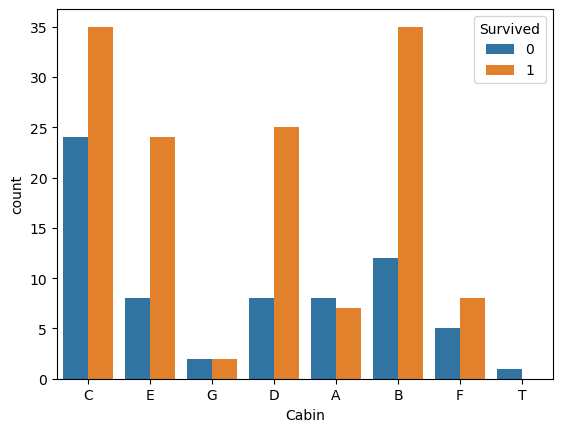

In [61]:
sns.countplot(data=train,x="Cabin",hue='Survived')
plt.show()

In [62]:
train['Cabin'].value_counts().sum()

204

In [63]:
# use the crosstab to create a contingency table to run chi2 on
contable = pd.crosstab(train['Cabin'],train['Survived'])

# the chi2 returns 4 variables, chi2, p, expected frequency, additional info. the _ indicates the value is not used
chi2,p,_,_ = chi2_contingency(contable)
print(chi2,p)

10.300556313502582 0.1721713412821439


Another thing I did not account for was the cabin not really having any significance to survival, even though cabin B has a significantly higher chance of survival, there were likely not enough values to justify keeping them

### Clean Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
test = pd.read_csv('F:/data science/Jupyter/work file/datasets/competitions/titanic/test.csv')
train = pd.read_csv('F:/data science/Jupyter/work file/datasets/competitions/titanic/train.csv')
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

drop unimportant columns, name, ticket, fare

In [3]:
train = train.drop(columns = ['Name','Ticket'])

fill age with the mean of age rounded to nearest whole number

In [4]:
train['Age'] = train['Age'].fillna(round(train['Age'].dropna().mean()))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


for cabin, I dont think the actual number matters, but rather the letter, so removing the number to guage it

In [5]:
train['Cabin'] = train['Cabin'].str.replace('\d','',regex=True)
train['Cabin'] = train['Cabin'].str.slice(0, 1)

get dummy vars for non numeric columns

In [6]:
train = pd.get_dummies(train, columns = ['Embarked'])
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,NaN,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,NaN,0,0,1
3,4,1,1,female,35.0,1,0,53.1000,C,0,0,1
4,5,0,3,male,35.0,0,0,8.0500,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,0,0,1
887,888,1,1,female,19.0,0,0,30.0000,B,0,0,1
888,889,0,3,female,30.0,1,2,23.4500,NaN,0,0,1
889,890,1,1,male,26.0,0,0,30.0000,C,1,0,0


make sex a binary value

In [7]:
train['Sex'] = train['Sex'].replace('female',0)
train['Sex'] = train['Sex'].replace('male',1)

assign a value to the child column to account for higher child survival

In [8]:
for val in train['Age']:
    if val <=17:
        train['Child'] = 1
    else:
        train['Child'] = 0

Drop cabin all together, the data does not support it enough

In [9]:
feat = train.drop(columns = ['PassengerId','Survived','Cabin'])
feat

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Child
0,3,1,22.0,1,0,7.2500,0,0,1,0
1,1,0,38.0,1,0,71.2833,1,0,0,0
2,3,0,26.0,0,0,7.9250,0,0,1,0
3,1,0,35.0,1,0,53.1000,0,0,1,0
4,3,1,35.0,0,0,8.0500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,0,0,1,0
887,1,0,19.0,0,0,30.0000,0,0,1,0
888,3,0,30.0,1,2,23.4500,0,0,1,0
889,1,1,26.0,0,0,30.0000,1,0,0,0


### Build Model

In [10]:
from sklearn.model_selection import train_test_split

feat_train, feat_test, target_train, target_test = train_test_split(feat, train['Survived'], test_size=0.2, random_state = 33)

standardize features and reduce features

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
# standardize the feature matrix

scaler = StandardScaler()

standfeat_train = scaler.fit_transform(feat_train)
standfeat_test = scaler.transform(feat_test)

In [13]:
# make PCA retain 90% of the variance of the original
pca = PCA(n_components = 0.90, whiten=True)

pcafeat_train = pca.fit_transform(standfeat_train)
pcafeat_test = pca.transform(standfeat_test)

print('original features:', standfeat_train.shape[1])
print('reduced features:', pcafeat_train.shape[1])

print('original features:', standfeat_test.shape[1])
print('reduced features:', pcafeat_test.shape[1])

original features: 10
reduced features: 7
original features: 10
reduced features: 7


import models to test

In [14]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

build a dictionary to loop through in order to test multiple different models at once

In [15]:
model_param1 = {
    'svc':{
        'model': SVC(gamma='auto'),
        'params':{
            'C':[5,10,20],
            'kernel':['linear','rbf']
        }
    },
    'randfor':{
        'model': RandomForestClassifier(),
        'params':{
            'n_estimators':[50,100,200]
        }
    }
}
model_param2 = {
    'knn':{
        'model': KNeighborsClassifier(),
        'params':{
            'n_neighbors':[2,5,8,10],
            'algorithm':['ball_tree','kd_tree']
        }
    },
    'logreg':{
        'model': LogisticRegression(max_iter=1000),
        'params':{
            'C':[5,10,20],
            'solver': ['lbfgs','liblinear']
        }
    }
}

In [16]:
# this code is built to loop through the dictionary built previously and try different models and parameters to see which performs best

scores = []

for model_name, mp in model_param2.items():
    search = GridSearchCV(mp['model'],mp['params'], cv=5)
    search.fit(pcafeat_train, target_train)
    scores.append({
        'model': model_name,
        'best_score': search.best_score_,
        'best_params': search.best_params_
    })

In [17]:
score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
score_df

,model,best_score,best_params
0,knn,0.810381,"{'algorithm': 'ball_tree', 'n_neighbors': 10}"
1,logreg,0.800561,"{'C': 5, 'solver': 'lbfgs'}"


In [18]:
scores1 = []

for model_name, mp in model_param1.items():
    search = GridSearchCV(mp['model'],mp['params'], cv=5)
    search.fit(pcafeat_train, target_train)
    scores1.append({
        'model': model_name,
        'best_score': search.best_score_,
        'best_params': search.best_params_
    })

In [19]:
score_df1 = pd.DataFrame(scores1,columns=['model','best_score','best_params'])
score_df1

,model,best_score,best_params
0,svc,0.813198,"{'C': 5, 'kernel': 'rbf'}"
1,randfor,0.787905,{'n_estimators': 50}


In [20]:
svc = SVC(gamma='auto',C=5,kernel='rbf')
model = svc.fit(pcafeat_train, target_train)

In [21]:
model.score(pcafeat_test,target_test)

0.8379888268156425

### prep the test data

In [24]:
test = pd.read_csv('F:/data science/Jupyter/work file/datasets/competitions/titanic/test.csv')

# drop unimportant columns
test = test.drop(columns = ['Name','Ticket'])

# fill age with the mean
test['Age'] = test['Age'].fillna(round(test['Age'].dropna().mean()))
test['Fare'] = test['Fare'].fillna(round(test['Fare'].dropna().mean()))

# make sex binary
test['Sex'] = test['Sex'].replace('female',0)
test['Sex'] = test['Sex'].replace('male',1)

# make dummy columns
test = pd.get_dummies(test, columns = ['Embarked'])

# add child column
for val in test['Age']:
    if val <=17:
        test['Child'] = 1
    else:
        test['Child'] = 0
        
# drop unimportant columns
feat = test.drop(columns = ['PassengerId','Cabin'])
# feat.info()

# scale responses
standfeat_test = scaler.transform(feat)

# pca to reduce features
pcafeat_test = pca.transform(standfeat_test)



In [25]:
feat

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Child
0,3,1,34.5,0,0,7.8292,0,1,0,0
1,3,0,47.0,1,0,7.0000,0,0,1,0
2,2,1,62.0,0,0,9.6875,0,1,0,0
3,3,1,27.0,0,0,8.6625,0,0,1,0
4,3,0,22.0,1,1,12.2875,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
413,3,1,30.0,0,0,8.0500,0,0,1,0
414,1,0,39.0,0,0,108.9000,1,0,0,0
415,3,1,38.5,0,0,7.2500,0,0,1,0
416,3,1,30.0,0,0,8.0500,0,0,1,0


In [30]:
prediction = pd.DataFrame(model.predict(pcafeat_test),columns=['Survived'])
prediction

,Survived
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [36]:
test['Survived'] = prediction
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Child,Suvived,Survived
0,892,3,1,34.5,0,0,7.8292,NaN,0,1,0,0,0,0
1,893,3,0,47.0,1,0,7.0000,NaN,0,0,1,0,0,0
2,894,2,1,62.0,0,0,9.6875,NaN,0,1,0,0,0,0
3,895,3,1,27.0,0,0,8.6625,NaN,0,0,1,0,0,0
4,896,3,0,22.0,1,1,12.2875,NaN,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,30.0,0,0,8.0500,NaN,0,0,1,0,0,0
414,1306,1,0,39.0,0,0,108.9000,C105,1,0,0,0,1,1
415,1307,3,1,38.5,0,0,7.2500,NaN,0,0,1,0,0,0
416,1308,3,1,30.0,0,0,8.0500,NaN,0,0,1,0,0,0


In [45]:
submission = test[['PassengerId','Survived']]
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [47]:
submission.to_csv('tomferko_titanic_submission.csv',index=False)